# Prediction Coffee Grade

## Modeling

## Table of Contents

* [1. Import Libraries](#import)
* [2. Download Data](#download)
    * [2.1 Dealing with Categorical, Train-Test-Split, and Scaling](#categorical)
    * [2.2 Defining Useful Functions](#useful)
* [3. Defining Model Success](#model_success)
* [4. Logistic Regression Model](#log_reg)
     * [4.1 Logistic Regression- Out-of-the-Box](#log_reg_ootb)
     * [4.2 Logistic Regression with PCA](#log_reg_pca)
     * [4.3 Tuning Hyperparameters of Logistic Regression with GridSearch](#log_reg_tuning)
* [5. Random Forest Classifier Model](#rf)
     * [5.1 Random Forest- Out-of-the-Box](#rf_ootb)
     * [5.2 Accounting for Imbalanced Data Set](#imbalanced)
          * [5.2a Random Forest With Class Weighting](#rf_class_weighting)
          * [5.2b Random Forest With Bootstrap Class Weighting](#rf_bootstrap)
          * [5.2c Random Forest With Random Undersampling](#rf_random_undersampling)
     * [5.3 Tuning Hyperparameters of the Random Forest Classifier](#rf_tuning)
     * [5.4 Finding Important Features](#features)
* [6. Gradient Boosting Model](#gb)
     * [6.1 Gradient Boosting Model - Out of the Box](#gb_ootb)
     * [6.2 Tuning Hyperparametrs of Gradient Boosting Model](#gb_tuning)
* [7. CatBoost Model](#cat)
     * [7.1 Catboost Model - Out of the Box](#cat_ootb)
     * [7.2 Tuning Hyperparametrs of CatBoost Model](#cat_tuning)
* [8. Conclusions](#conclusions)

<a class="anchor" id="import"></a>
## 1. Import Libraries

In [1]:
#import libraries

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA

from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier

import catboost
from catboost import CatBoostClassifier, Pool, metrics, cv

In [2]:
import warnings
warnings.filterwarnings('ignore')

<a class="anchor" id="download"></a>

## 2. Download Data

In [4]:
coffee3 = pd.read_csv('../data/coffee3.csv')

In [5]:
coffee3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         150 non-null    int64  
 1   Country of Origin  150 non-null    object 
 2   Variety            150 non-null    object 
 3   Mean Altitude (m)  150 non-null    float64
 4   Harvest Year       150 non-null    int64  
 5   Processing Method  150 non-null    object 
 6   Moisture           150 non-null    float64
 7   Color              150 non-null    object 
 8   Coffee_Grade       150 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 10.7+ KB


In [6]:
coffee3 = coffee3.drop(columns=['Unnamed: 0'])

<a class="anchor" id="categorical"></a>

### 2.1 Dealing with categorical, train_test_split and scaling 

First let's get our target feature y and our predictive features X.

In [7]:
X = coffee3.drop('Coffee_Grade', axis=1)
        
y = coffee3['Coffee_Grade']
X.shape, y.shape

((150, 7), (150,))

We will use pandas, get_dummies to encode our categorical data.

In [8]:
X_dumm = pd.get_dummies(X, drop_first=True)
X_dumm.shape

(150, 19)

Now we will split our data in train and test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size = 0.25, random_state=10)

Finally we will apply sklearn's StandardScaler.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<a class="anchor" id="useful"></a>

### 2.2 Defining useful functions 
Now we will crate a few functions to help us:

 * Getting the Evaluation Metrics from our classification models:
    * Accuracy - for both Train and Test
    * Cohen's Kappa - for both Train and Test
    * Classification report - which includes the F1 score, Recall and Precision for both predicted classes.
    * Confusion matrix - normalized.
    
 * Creating a Results Data Frame
 * Performing a Random Search of Parameters
 * Performing a Grid Search of Parameters

In [11]:
#printing classification report and confusion matrix
def evaluation_block(model):
    global train_acc, test_acc
    
    y_tr_pred = model.predict(X_train)
    
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    #train_logloss = round(log_loss(y_train,y_tr_pred),4)
    #test_logloss = round(log_loss(y_test,y_pred),4)
    
    print("Train - Accuracy:", train_acc)
    print("Test - Accuracy:", test_acc)
    print("Train - F1:", train_f1)
    print("Test - F1:", test_f1)
    

    print('Validation - Classification report\n', classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = 'Blues')
    plt.show()

In [12]:
#create a dataframe to store and compare our model results
results = pd.DataFrame(columns = ['model','name','train_accuracy', 'test_accuracy', 'train_f1', 'test_f1'])
pd.set_option("max_colwidth", 100)
def save_scores(model, name):
    y_tr_pred = model.predict(X_train)
    
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='micro'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='micro'),4)
    
    
    new_row = {'model':model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1,
              
              }
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

In [13]:
#create function to perform random search on a given model and parameter grid
def rand_cv(model, param_grid, name):
    # Random search of parameters, using 3 fold cross validation, 
    random = RandomizedSearchCV(estimator = model, param_distributions = param_grid ,n_iter=100, cv = 3, verbose=2, random_state=10, n_jobs = -1)
    random.fit(X_train, y_train)
    print('Best Parameters based on Randomized Search CV:', random.best_params_)
    print('Best score: ', random.best_score_)
    evaluation_block(random)
    save_scores(random, name)

In [14]:
#create function to perform grid search on a given model and parameter grid
def grid_cv(model, param_grid, name):
    grid = GridSearchCV(model, param_grid, cv = 3)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

    print('Best Parameters based on Grid Search CV: ', grid.best_params_)
    print('Best Score: ', grid.best_score_)
    evaluation_block(grid)
    save_scores(grid, name)

<a class="anchor" id="model_success"></a>

## 3. Defining Model Success

Because we will be conducting tests on multiple models, we need a way to compare them to choose the 'best' model. For our particular context -- that is, coffee grade predictions -- it is important that a coffee is graded accurately. If coffee is graded higher than it should be, the customer will feel like they are being lied to or ripped off. They expect a certain quality and are receiving a worse quality product. On the other hand, coffee that is graded lower than it should be means that the seller is not receiving just compensation for the quality of the product they are selling. Though both errors are important to consider, I think that most businesses would rather make the mistake of selling REALLY good low-grade coffee than REALLY bad "specialty" coffee. So, though Accuracy and F1 score will be important metrics to consider while conducting our tests, we want to also look at the model closely as to what is being labeled what. In other words, given a similar Accuracy and F1 score, does one model tend to label coffees ABOVE or BELOW the actual grade compared to others. In these instances, the model that tends to low-ball the coffee grade, so-to-speak, will be prefered. 

<a class="anchor" id="log_reg"></a>

## 4. Logistic Regression Model

<a class="anchor" id="log_reg_ootb"></a>
### 4.1 Logistic Regression - Out of the Box

For our initial model we will start off with logistic regression

In [15]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

Train - Accuracy: 0.7589
Test - Accuracy: 0.7105
Train - F1: 0.7551
Test - F1: 0.6724
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.69      0.95      0.80        21
       Specialty       0.78      0.47      0.58        15

        accuracy                           0.71        38
       macro avg       0.49      0.47      0.46        38
    weighted avg       0.69      0.71      0.67        38



<Figure size 648x648 with 0 Axes>

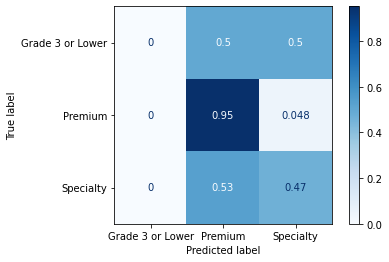

In [16]:
evaluation_block(logisticRegr)

The score for the out of the box LogisticRegression model is: 0.71 accuracy and 0.41 Cohen Kappa score.

In [17]:
save_scores(logisticRegr, 'Log Reg Out of the Box')

In [18]:
results

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105


<a class="anchor" id="log_reg_pca"></a>

### 4.2 Logistic regression with PCA

The out of the box model can be improved by either tunning the hyperparameters or by further modifing the data prior to applying the classifiers.

We will now see how PCA affects our LogisticRegression model.

In [19]:
pca = PCA()
pca.fit(X_train)

PCA()

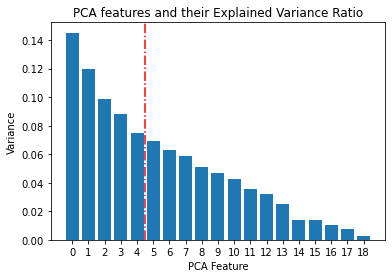

In [20]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.axvline(4.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

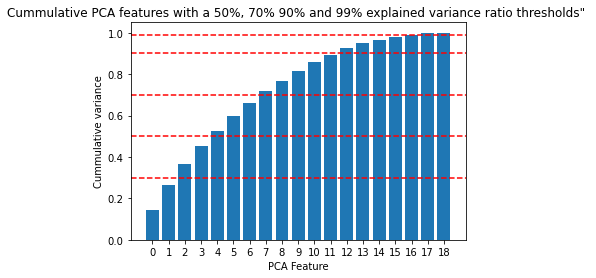

In [21]:
plt.bar(features, np.cumsum(pca.explained_variance_ratio_))
[plt.axhline(y=i, linestyle='--', c = 'red') for i in [.3,.5,.7,.9, 0.99]]
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

Based on our PCA decomposition we can choose the folowing number of principal components:

* 2 - for about 30% explained variance
* 4 - for >50% explained variance
* 7 - for >70% explained variance
* 12 - for >90% explained variance
* 17 - for >99% explained variance

Obviously we need to consider the fact that a model based on fewer features will be underfitting while one based on a lot of them will ussualy overfit.

Another aspect when considering underfitting vs overfitting is the dataset size, and in this case the training data has barely over 100 records, so considering we are dealing with a rather small dataset we can can't choose more features without a high risk of overfitting. We will check that by comparing the metrics from our training set versus the scores our models produces on the test set.

---------------------Train & Test scores : Log reg model with 2 PCA features-------------------
Train - Accuracy:  0.5089
Test - Accuracy:  0.6316
Train - F1: 0.4724 
Test - F1: 0.5834 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.63      0.90      0.75        21
       Specialty       0.62      0.33      0.43        15

        accuracy                           0.63        38
       macro avg       0.42      0.41      0.39        38
    weighted avg       0.60      0.63      0.58        38



<Figure size 648x648 with 0 Axes>

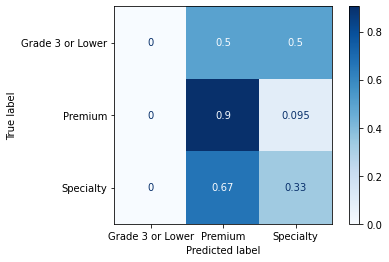

---------------------Train & Test scores : Log reg model with 4 PCA features-------------------
Train - Accuracy:  0.6429
Test - Accuracy:  0.6579
Train - F1: 0.6084 
Test - F1: 0.627 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.67      0.86      0.75        21
       Specialty       0.64      0.47      0.54        15

        accuracy                           0.66        38
       macro avg       0.43      0.44      0.43        38
    weighted avg       0.62      0.66      0.63        38



<Figure size 648x648 with 0 Axes>

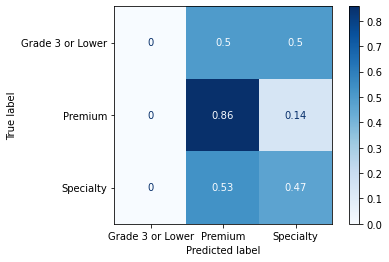

---------------------Train & Test scores : Log reg model with 7 PCA features-------------------
Train - Accuracy:  0.6786
Test - Accuracy:  0.6579
Train - F1: 0.6455 
Test - F1: 0.6431 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.71      0.81      0.76        21
       Specialty       0.62      0.53      0.57        15

        accuracy                           0.66        38
       macro avg       0.44      0.45      0.44        38
    weighted avg       0.63      0.66      0.64        38



<Figure size 648x648 with 0 Axes>

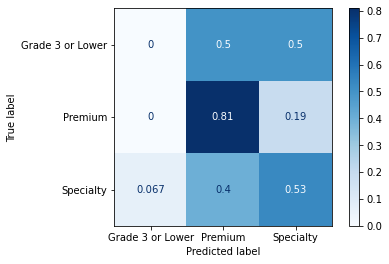

---------------------Train & Test scores : Log reg model with 12 PCA features-------------------
Train - Accuracy:  0.7232
Test - Accuracy:  0.6316
Train - F1: 0.7206 
Test - F1: 0.6222 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.71      0.81      0.76        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.63        38
       macro avg       0.43      0.43      0.42        38
    weighted avg       0.62      0.63      0.62        38



<Figure size 648x648 with 0 Axes>

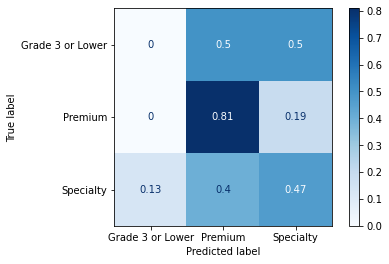

---------------------Train & Test scores : Log reg model with 17 PCA features-------------------
Train - Accuracy:  0.75
Test - Accuracy:  0.6579
Train - F1: 0.7464 
Test - F1: 0.6174 

                  precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.66      0.90      0.76        21
       Specialty       0.67      0.40      0.50        15

        accuracy                           0.66        38
       macro avg       0.44      0.43      0.42        38
    weighted avg       0.63      0.66      0.62        38



<Figure size 648x648 with 0 Axes>

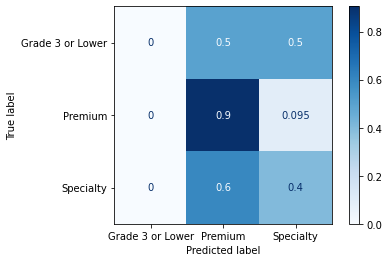

In [22]:
pca_feat = [2,4,7,12,17]
for i in pca_feat:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    X_train_i = pca.transform(X_train)
    X_test_i = pca.transform(X_test)

    logreg_model = LogisticRegression(max_iter=10000)
    logreg_model.fit(X_train_i, y_train)
    
    y_tr_pred = logreg_model.predict(X_train_i)
    y_tr_pred_prob = logreg_model.predict_proba(X_train_i)[:,1]
    
    y_pred = logreg_model.predict(X_test_i)
    y_pred_prob = logreg_model.predict_proba(X_test_i)[:,1]
    
    #add to results data frame
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)
    train_f1 = round(f1_score(y_train, y_tr_pred, average='weighted'),4)
    test_f1 = round(f1_score(y_test, y_pred, average='weighted'),4)
    model = logreg_model
    name = 'Log reg model with {} PCA features'.format(i)
    
    new_row = {'model':model,
               'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1}
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
    
    print('---------------------Train & Test scores : Log reg model with {} PCA features-------------------'.format(i))
    print('Train - Accuracy: ', round(accuracy_score(y_train,y_tr_pred),4))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))
    print('Train - F1: {} '.format(round(f1_score(y_train, y_tr_pred, average='weighted'),4)))        
    print('Test - F1: {} \n'.format(round(f1_score(y_test, y_pred, average='weighted'),4)))
    print(classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    plot_confusion_matrix(logreg_model, X_test_i, y_test, normalize='true', cmap = 'Blues')
    plt.show()
    
    
    
    

In [23]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


As we can see, changing the number of PCA features does not improve the accuracy of our model so for our further modeling we will keep our data without the PCA transformation.

<a class="anchor" id="log_reg_tuning"></a>
### 4.3 Tuning Hyperparameters of Logistic Regression with GridSearch

Let's first look at the list of parameters currently in use by our base logisic regression model

In [24]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(logisticRegr.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


Next we will create a parameter grid of all the parameters we'd like to test and perform our grid search.

In [25]:
param_grid = { 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'penalty' : ['none','l1', 'l2', 'elasticnet'],
                'C' : [100, 10, 1.0, 0.1, 0.01],
               'max_iter' : [10, 100, 1000, 10000]
             }

Best Parameters based on Grid Search CV:  {'C': 10, 'max_iter': 10, 'penalty': 'l2', 'solver': 'sag'}
Best Score:  0.6173541963015647
Train - Accuracy: 0.7411
Test - Accuracy: 0.6579
Train - F1: 0.7376
Test - F1: 0.6174
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.66      0.90      0.76        21
       Specialty       0.67      0.40      0.50        15

        accuracy                           0.66        38
       macro avg       0.44      0.43      0.42        38
    weighted avg       0.63      0.66      0.62        38



<Figure size 648x648 with 0 Axes>

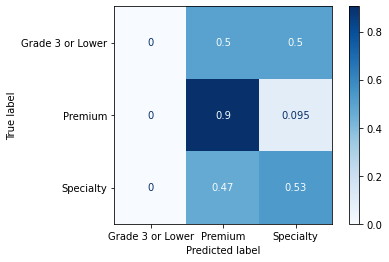

In [26]:
grid_cv(logisticRegr, param_grid, 'Log Reg w/ GridSearch')

Based on our results, the hypertuned model performed worse than our base model.

In [27]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


<a class="anchor" id="rf"></a>

## 5. Random Forest Classifier

<a class="anchor" id="rf_ootb"></a>

### 5.1 Random Forest Classifier - Out of the Box

In [28]:
rfc = RandomForestClassifier(random_state=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9909
Test - F1: 0.8451
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.33      0.50      0.40         2
         Premium       0.87      0.95      0.91        21
       Specialty       0.92      0.73      0.81        15

        accuracy                           0.84        38
       macro avg       0.71      0.73      0.71        38
    weighted avg       0.86      0.84      0.85        38



<Figure size 648x648 with 0 Axes>

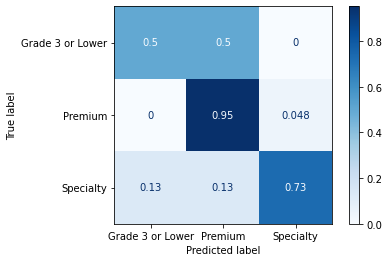

In [29]:
evaluation_block(rfc)

Right off the bat we see a huge improvement in the evaluation metrics for this model compared to the logistic regression model.

In [30]:
save_scores(rfc, 'Random Forest Out of the Box')

In [31]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


<a class="anchor" id="imbalanced"></a>

### 5.2 Accounting for Imbalanced Data Set

Because our data classes are highly imbalanced, I want to test some hyperparameters to account for this. We will try 2 different iterations of our RandomForestClassifier model by adjusting the class_weight  

<a class="anchor" id="rf_class_weighting"></a>

#### 5.2a Random Forest With Class Weighting


In [32]:
rfc_balanced = RandomForestClassifier(class_weight='balanced', random_state = 10)
rfc_balanced.fit(X_train, y_train)
y_pred = rfc_balanced.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9912
Test - F1: 0.837
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.67      1.00      0.80         2
         Premium       0.83      0.95      0.89        21
       Specialty       0.91      0.67      0.77        15

        accuracy                           0.84        38
       macro avg       0.80      0.87      0.82        38
    weighted avg       0.85      0.84      0.84        38



<Figure size 648x648 with 0 Axes>

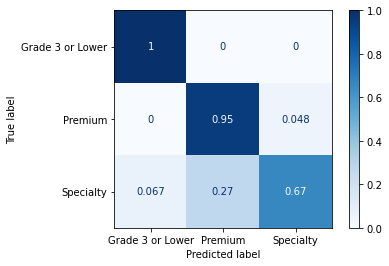

In [33]:
evaluation_block(rfc_balanced)

In [34]:
save_scores(rfc_balanced, 'Random Forest Balanced')

<a class="anchor" id="rf_bootstrap"></a>

#### 5.2b Random Forest With Bootstrap Class Weighting

In [35]:
rfc_balanced_subsample = RandomForestClassifier(class_weight='balanced_subsample', random_state = 10)
rfc_balanced_subsample.fit(X_train, y_train)
y_pred = rfc_balanced_subsample.predict(X_test)

Train - Accuracy: 0.9911
Test - Accuracy: 0.8421
Train - F1: 0.9912
Test - F1: 0.8411
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      1.00      0.67         2
         Premium       0.87      0.95      0.91        21
       Specialty       0.91      0.67      0.77        15

        accuracy                           0.84        38
       macro avg       0.76      0.87      0.78        38
    weighted avg       0.87      0.84      0.84        38



<Figure size 648x648 with 0 Axes>

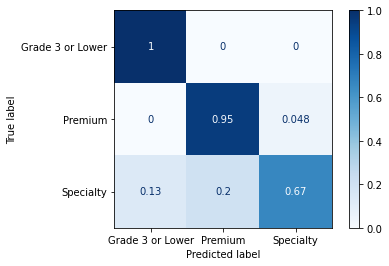

In [36]:
evaluation_block(rfc_balanced_subsample)

In [37]:
save_scores(rfc_balanced_subsample, 'Random Forest Balanced Subsample')

<a class="anchor" id="rf_random_undersampling"></a>

#### 5.2c Random Forest With Random Undersampling

In [38]:
brfc = BalancedRandomForestClassifier(random_state = 10)
brfc.fit(X_train, y_train)
y_pred = brfc.predict(X_test)

Train - Accuracy: 0.7679
Test - Accuracy: 0.6053
Train - F1: 0.7747
Test - F1: 0.6225
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.25      1.00      0.40         2
         Premium       0.78      0.67      0.72        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.61        38
       macro avg       0.54      0.71      0.55        38
    weighted avg       0.67      0.61      0.62        38



<Figure size 648x648 with 0 Axes>

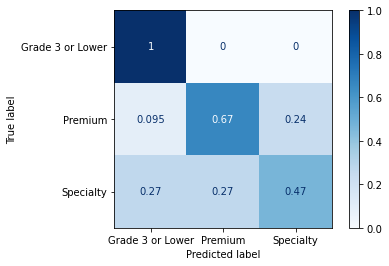

In [39]:
evaluation_block(brfc)

In [40]:
save_scores(brfc, 'Balanced Random Forest Classifier')

In [41]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


Based on these three models, our rfc_balanced model performed the best. Though they had similar accuracy and overall F1 scores, the precision and recall scores for the individual classes were better. The rfc_balanced model did a better job at not giving the coffees a HIGHER grade than what they were.

<a class="anchor" id="rf_tuning"></a>

### 5.3 Tuning Hyperparameters of the Random Forest Classifier

In [42]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(rfc_balanced.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 10,
 'verbose': 0,
 'warm_start': False}


### We will try to fine tune the following:

n_estimators = number of trees in the foreset

max_features = max number of features considered for splitting a node

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

### Use Randomized Search to find best parameters

In [43]:
param_grid = {   'bootstrap': [True, False],
                 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
                 'max_features': ['auto', 'sqrt'],
                 'min_samples_leaf': [1, 2, 4],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [10, 50, 75, 100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]
             }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Best score:  0.7245139876718825
Train - Accuracy: 0.9911
Test - Accuracy: 0.6053
Train - F1: 0.9912
Test - F1: 0.6225
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.25      1.00      0.40         2
         Premium       0.78      0.67      0.72        21
       Specialty       0.58      0.47      0.52        15

        accuracy                           0.61        38
       macro avg       0.54      0.71      0.55        38
    weighted avg       0.67      0.61      0.62        38



<Figure size 648x648 with 0 Axes>

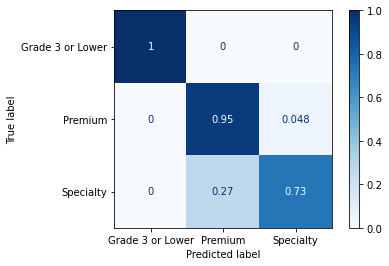

In [44]:
rand_cv(rfc_balanced, param_grid, 'Random Forest Balanced RandomSearch')

In [45]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
2,LogisticRegression(max_iter=10000),Log reg model with 4 PCA features,0.6429,0.6579,0.6084,0.6270
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
1,LogisticRegression(max_iter=10000),Log reg model with 2 PCA features,0.5089,0.6316,0.4724,0.5834
4,LogisticRegression(max_iter=10000),Log reg model with 12 PCA features,0.7232,0.6316,0.7206,0.6222


<a class="anchor" id="features"></a>
### 5.4 Finding Important Features

In [46]:
#Finding Important Features:
feature_imp = pd.Series(rfc_balanced.feature_importances_,index=X_dumm.columns).sort_values(ascending=False)
feature_imp

Moisture                                    0.267662
Mean Altitude (m)                           0.247171
Harvest Year                                0.073540
Country of Origin_Other                     0.071899
Country of Origin_Guatemala                 0.046501
Processing Method_Washed / Wet              0.045999
Variety_Other                               0.037284
Color_Green                                 0.032623
Variety_Caturra                             0.030219
Variety_Catuai                              0.026511
Country of Origin_Ethiopia                  0.024923
Country of Origin_Colombia                  0.019432
Color_None                                  0.019325
Variety_SL28                                0.015218
Country of Origin_Costa Rica                0.013778
Processing Method_Pulped natural / honey    0.009939
Color_Yellow-Green                          0.009094
Color_Greenish                              0.005727
Processing Method_Other                     0.

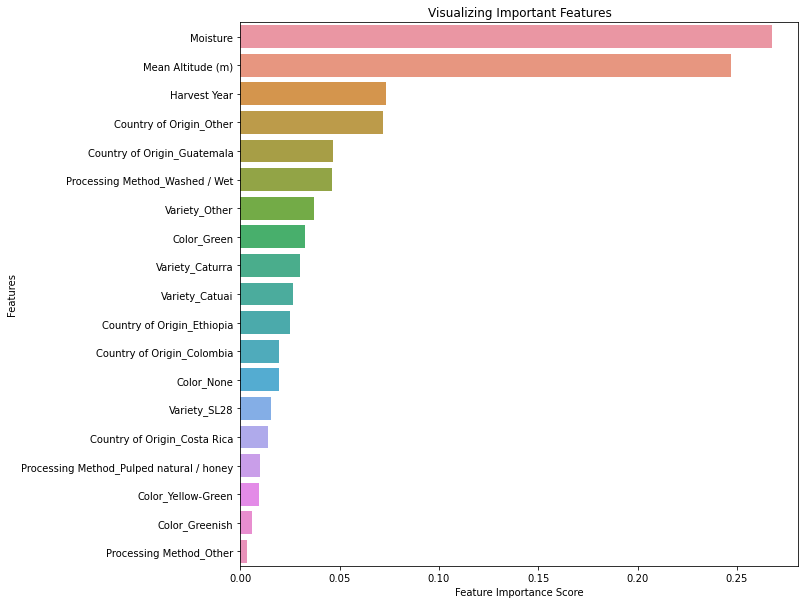

In [47]:
#Visualizing Important Features

%matplotlib inline
# Creating a bar plot
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [48]:
#sorting features by importance
feat_sorted_idx = np.argsort(feature_imp)

In [49]:
# Choosing most important top 4,9,and 13 features.
top2_feat = X_dumm.columns[feat_sorted_idx][-2:]
top4_feat = X_dumm.columns[feat_sorted_idx][-4:]
top10_feat = X_dumm.columns[feat_sorted_idx][-10:]
top2_feat, top4_feat, top10_feat

(Index(['Harvest Year', 'Mean Altitude (m)'], dtype='object'),
 Index(['Country of Origin_Colombia', 'Moisture', 'Harvest Year',
        'Mean Altitude (m)'],
       dtype='object'),
 Index(['Variety_Caturra', 'Variety_Catuai', 'Country of Origin_Other',
        'Country of Origin_Guatemala', 'Country of Origin_Ethiopia',
        'Country of Origin_Costa Rica', 'Country of Origin_Colombia',
        'Moisture', 'Harvest Year', 'Mean Altitude (m)'],
       dtype='object'))

In [50]:
print('The Predictive features subsets have {}, {}, and {} features respectively.'.format(len(top2_feat), len(top4_feat), len(top10_feat)))

The Predictive features subsets have 2, 4, and 10 features respectively.


----------Random forest model on train set with 2 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.8482
Test - Accuracy: 0.5
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         5
         Premium       0.52      0.81      0.63        16
       Specialty       0.67      0.35      0.46        17

        accuracy                           0.50        38
       macro avg       0.40      0.39      0.37        38
    weighted avg       0.52      0.50      0.47        38



<Figure size 648x648 with 0 Axes>

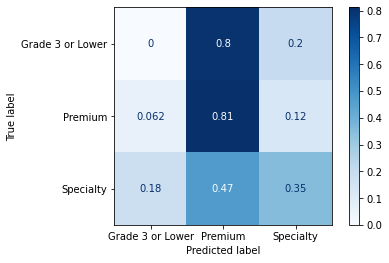

Train Cohen Kappa: 0.7153
Test Cohen Kappa: 0.1711
RandomForestClassifier(class_weight='balanced', random_state=10)
Train - Accuracy: 0.8393
Test - Accuracy: 0.5263
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.29      0.40      0.33         5
         Premium       0.52      0.75      0.62        16
       Specialty       0.75      0.35      0.48        17

        accuracy                           0.53        38
       macro avg       0.52      0.50      0.48        38
    weighted avg       0.59      0.53      0.52        38



<Figure size 648x648 with 0 Axes>

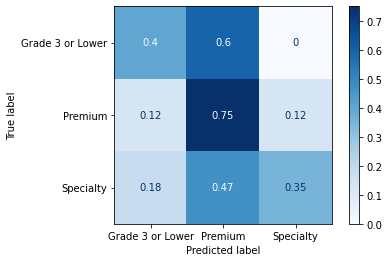

Train Cohen Kappa: 0.7122
Test Cohen Kappa: 0.2442
----------Random forest model on train set with 4 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.9643
Test - Accuracy: 0.6053
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       1.00      1.00      1.00         4
         Premium       0.57      0.67      0.62        18
       Specialty       0.54      0.44      0.48        16

        accuracy                           0.61        38
       macro avg       0.70      0.70      0.70        38
    weighted avg       0.60      0.61      0.60        38



<Figure size 648x648 with 0 Axes>

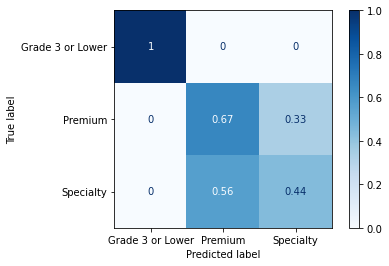

Train Cohen Kappa: 0.9358
Test Cohen Kappa: 0.323
RandomForestClassifier(class_weight='balanced', random_state=10)
Train - Accuracy: 0.9643
Test - Accuracy: 0.6579
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       1.00      1.00      1.00         4
         Premium       0.61      0.78      0.68        18
       Specialty       0.64      0.44      0.52        16

        accuracy                           0.66        38
       macro avg       0.75      0.74      0.73        38
    weighted avg       0.66      0.66      0.65        38



<Figure size 648x648 with 0 Axes>

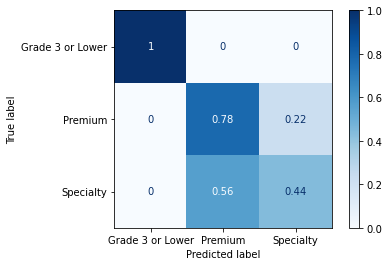

Train Cohen Kappa: 0.9358
Test Cohen Kappa: 0.4105
----------Random forest model on train set with 10 most important features-------
RandomForestClassifier(random_state=10)
Train - Accuracy: 0.9911
Test - Accuracy: 0.7105
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      0.50      0.50         2
         Premium       0.68      0.83      0.75        18
       Specialty       0.79      0.61      0.69        18

        accuracy                           0.71        38
       macro avg       0.66      0.65      0.65        38
    weighted avg       0.72      0.71      0.71        38



<Figure size 648x648 with 0 Axes>

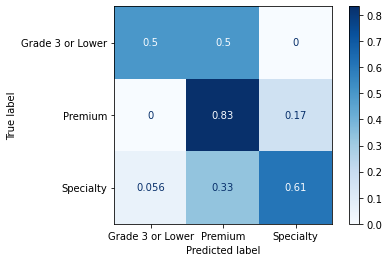

Train Cohen Kappa: 0.9841
Test Cohen Kappa: 0.4722
RandomForestClassifier(class_weight='balanced', random_state=10)
Train - Accuracy: 0.9911
Test - Accuracy: 0.7105
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      0.50      0.50         2
         Premium       0.68      0.83      0.75        18
       Specialty       0.79      0.61      0.69        18

        accuracy                           0.71        38
       macro avg       0.66      0.65      0.65        38
    weighted avg       0.72      0.71      0.71        38



<Figure size 648x648 with 0 Axes>

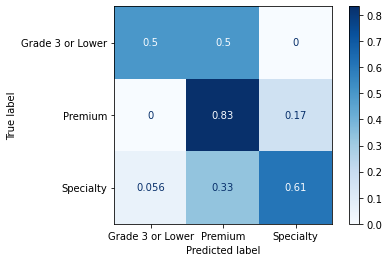

Train Cohen Kappa: 0.9841
Test Cohen Kappa: 0.4722


In [51]:
def selecting_features():
    for columns_set in [top2_feat, top4_feat, top10_feat]:
        X = X_dumm[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
        print('----------Random forest model on train set with {} most important features-------'.format(len(columns_set)))
        for rfc_model in [rfc, rfc_balanced]:
            print(rfc_model)
            rfc_model.fit(X_train, y_train)
            y_pred = rfc_model.predict(X_test)
            
            y_tr_pred = rfc_model.predict(X_train)
    
            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)
            train_f1 = round(f1_score(y_train, y_tr_pred, average = 'weighted'),4)
            test_f1 = round(f1_score(y_test, y_pred, average = 'weighted'),4)
            
            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            plot_confusion_matrix(rfc_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()
            
            y_pred_prob = rfc_model.predict_proba(X_test)[:,1]
            y_tr_pred_prob = rfc_model.predict_proba(X_train)[:,1]
            
            train_cohen = round(cohen_kappa_score(y_train, y_tr_pred),4)
            test_cohen = round(cohen_kappa_score(y_test, y_pred),4)
        
            #train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
            #test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
        
            print('Train Cohen Kappa: {}'.format(train_cohen))
            print('Test Cohen Kappa: {}'.format(test_cohen))
            
            name = '{} with top {} features'.format(rfc_model, len(columns_set))
            
            new_row = {'model':rfc_model,
                       'name': name,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_f1': train_f1,
               'test_f1': test_f1}
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row
            
selecting_features()

In [52]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
16,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForestClassifier(random_state=10) with top 10 features,0.9911,0.7105,0.9909,0.7072
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
17,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced', random_state=10) with top 10 features",0.9911,0.7105,0.9909,0.7072
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
3,LogisticRegression(max_iter=10000),Log reg model with 7 PCA features,0.6786,0.6579,0.6455,0.6431
15,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced', random_state=10) with top 4 features",0.9643,0.6579,0.9643,0.6471


Based on our results, the best reduced-feature model was produced by the reducing the number of features to 4 but it does not give a better model performance than our original models.

<a class="anchor" id="gb"></a>

## 6. Gradient Boosting Model

Pros: 
    good for heterogeneous data
    easy to use
    works well for small data
    

<a class="anchor" id="gb_ootb"></a>

### 6.1 Gradient Boosting Model - Out of the Box

In [53]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)

Train - Accuracy: 0.9732
Test - Accuracy: 0.7632
Train - F1: 0.9731
Test - F1: 0.7604
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      0.50      0.50         2
         Premium       0.78      0.86      0.82        21
       Specialty       0.77      0.67      0.71        15

        accuracy                           0.76        38
       macro avg       0.68      0.67      0.68        38
    weighted avg       0.76      0.76      0.76        38



<Figure size 648x648 with 0 Axes>

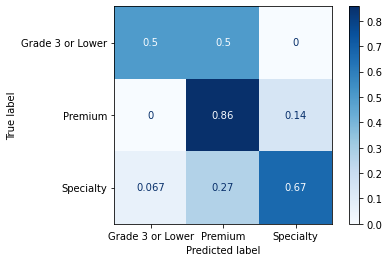

In [54]:
evaluation_block(gbc)

In [55]:
save_scores(gbc, 'Gradient Boosting Out of the Box')

<a class="anchor" id="gb_tuning"></a>

### 6.2 Tuning Hyperparameters of Gradient Boosting Model

In [56]:
#Check out parameters currently in use
print('Parameters currently in use:\n')
pprint(gbc.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


### most important parameters are:
Criterion: The loss function used to find the optimal feature and threshold to split the data

learning_rate: this parameter scales the contribution of each tree

max_depth: the maximum depth of each tree

n_estimators: the number of trees to construct

init: the initial estimator. By default, it is the log(odds) converted to a probability

In [57]:
param_grid = {  'criterion' : ['friedman_mse', 'mse', 'mae'],
                'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
                'max_depth' : np.linspace(1, 32, 32, endpoint=True),
                'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
                'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
                'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
                'max_features' : list(range(1,coffee3.shape[1]))
             }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters based on Randomized Search CV: {'n_estimators': 16, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 3, 'max_depth': 26.0, 'learning_rate': 0.5, 'criterion': 'friedman_mse'}
Best score:  0.6970128022759602
Train - Accuracy: 0.8482
Test - Accuracy: 0.7632
Train - F1: 0.8467
Test - F1: 0.7604
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.50      0.50      0.50         2
         Premium       0.78      0.86      0.82        21
       Specialty       0.77      0.67      0.71        15

        accuracy                           0.76        38
       macro avg       0.68      0.67      0.68        38
    weighted avg       0.76      0.76      0.76        38



<Figure size 648x648 with 0 Axes>

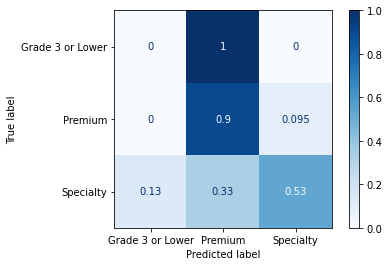

In [58]:
rand_cv(gbc, param_grid, 'Gradient Boosting RandomSearch')

In [59]:
results.sort_values('test_accuracy', ascending = False).head(15)

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
19,"RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,\n ...",Gradient Boosting RandomSearch,0.8482,0.7632,0.8482,0.7632
18,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",Gradient Boosting Out of the Box,0.9732,0.7632,0.9732,0.7632
17,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced', random_state=10) with top 10 features",0.9911,0.7105,0.9909,0.7072
16,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForestClassifier(random_state=10) with top 10 features,0.9911,0.7105,0.9909,0.7072
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105
6,"GridSearchCV(cv=3, estimator=LogisticRegression(),\n param_grid={'C': [100, 10, 1.0,...",Log Reg w/ GridSearch,0.7411,0.6579,0.7411,0.6579
5,LogisticRegression(max_iter=10000),Log reg model with 17 PCA features,0.7500,0.6579,0.7464,0.6174


Though our Gradient Boost model performed better than the Logistic Regression models, it did not perform better than the Random Forest Balanced model.

<a class="anchor" id="cat"></a>

## 7. Catboost Model

Lastly we will try the Catboost Model on our data. Catboost is a good model to use with categorical data, performs well with default parameters and comes with sophisticated model analysis tools.

In [61]:
#use df with categorical features (no need to label encode)
coffee3 = pd.read_csv('../data/coffee3.csv')
coffee3 = coffee3.drop(columns=['Unnamed: 0'])

In [62]:
coffee3.columns

Index(['Country of Origin', 'Variety', 'Mean Altitude (m)', 'Harvest Year',
       'Processing Method', 'Moisture', 'Color', 'Coffee_Grade'],
      dtype='object')

In [63]:
X = coffee3.drop('Coffee_Grade', axis=1)        
y  = coffee3['Coffee_Grade']
X.shape, y.shape

((150, 7), (150,))

The Catboost model requires labeling the categorical features. We will create an array of our categorical feature indices.

In [64]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([0, 1, 3, 4, 6])

We can account for the unbalanced nature of our data set using the class_weights parameter within the model. We will find the percentages of each of our 3 classes and subtract them from 100 to get the weights of each class.

In [65]:
#find class weights for class_wights parameter
round( coffee3['Coffee_Grade'].value_counts(normalize=True) * 100 , 2)

Premium             52.67
Specialty           38.67
Grade 3 or Lower     8.67
Name: Coffee_Grade, dtype: float64

<a class="anchor" id="cat_ootb"></a>

### 7.1 CatBoost - Out of the Box

Because we have 3 classes, we will be using the Cat Boost Classifier model with loss_function = 'MultiClass'

In [66]:
cat = CatBoostClassifier(loss_function='MultiClass', class_weights = [(100-8.67), (100-52.67), (100-38.67)], eval_metric = 'Accuracy', cat_features=categorical_features_indices)

In [67]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=10)

cat.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_test, y_test), verbose=False)

In [68]:
print(cat.get_best_score())

{'learn': {'Accuracy': 1.0, 'MultiClass': 0.025720976721614136}, 'validation': {'Accuracy': 0.7640684183310122, 'MultiClass': 0.6258123975934392}}


In [69]:
y_pred = cat.predict(X_test)
y_tr_pred = cat.predict(X_train)

Train - Accuracy: 0.6696
Test - Accuracy: 0.7895
Train - F1: 0.6393
Test - F1: 0.7693
Validation - Classification report
                   precision    recall  f1-score   support

Grade 3 or Lower       0.00      0.00      0.00         2
         Premium       0.85      0.81      0.83        21
       Specialty       0.72      0.87      0.79        15

        accuracy                           0.79        38
       macro avg       0.52      0.56      0.54        38
    weighted avg       0.75      0.79      0.77        38



<Figure size 648x648 with 0 Axes>

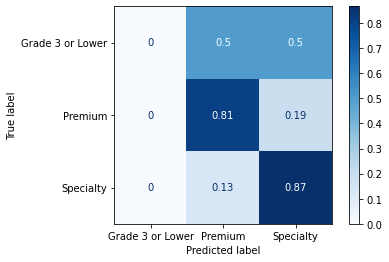

In [70]:
evaluation_block(cat)

Here we can see that our accuracy for our test set is decent but not as good as our out-of-the-box Random Forest Classifier. Our confusion matrix is also showing poorer results regarding our labeling.

In [71]:
save_scores(cat, "Catboost Out of the Box")

<a class="anchor" id="cat_tuning"></a>

### 7.2 Tuning Hyperparameters of CatBoost Model

In [72]:
cat.get_params()

{'loss_function': 'MultiClass',
 'class_weights': [91.33, 47.33, 61.33],
 'eval_metric': 'Accuracy',
 'cat_features': array([0, 1, 3, 4, 6])}

In [73]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200]
          
          }

Fitting 3 folds for each of 100 candidates, totalling 300 fits
0:	learn: 0.4428554	total: 730us	remaining: 182ms
1:	learn: 0.4428554	total: 3.76ms	remaining: 466ms
2:	learn: 0.4267774	total: 5.26ms	remaining: 433ms
3:	learn: 0.4415982	total: 5.95ms	remaining: 366ms
4:	learn: 0.4415982	total: 6.55ms	remaining: 321ms
5:	learn: 0.4298039	total: 7.18ms	remaining: 292ms
6:	learn: 0.4298039	total: 7.88ms	remaining: 274ms
7:	learn: 0.4298039	total: 8.8ms	remaining: 266ms
8:	learn: 0.4319958	total: 9.71ms	remaining: 260ms
9:	learn: 0.4298039	total: 10.4ms	remaining: 250ms
10:	learn: 0.4298039	total: 11ms	remaining: 239ms
11:	learn: 0.4415982	total: 11.6ms	remaining: 230ms
12:	learn: 0.4415982	total: 12.3ms	remaining: 223ms
13:	learn: 0.4459821	total: 13ms	remaining: 219ms
14:	learn: 0.4459821	total: 13.7ms	remaining: 214ms
15:	learn: 0.5216551	total: 14.4ms	remaining: 211ms
16:	learn: 0.5216551	total: 15.2ms	remaining: 209ms
17:	learn: 0.5216551	total: 15.9ms	remaining: 205ms
18:	learn: 0.5120

<Figure size 648x648 with 0 Axes>

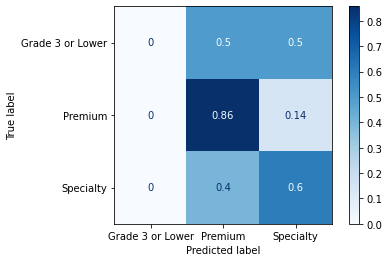

In [74]:
rand_cv(cat, params, "CatBoost w/ Random Search")

In [77]:
ordered_results = results.sort_values('test_accuracy', ascending = False).head(25)

In [87]:
pip install dataframe-image


     |████████████████████████████████| 648 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 124 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 5.6 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [76]:
import dataframe_image as dfi

In [91]:
dfi.export(ordered_results, '../docs/coffee_results.png')

In [78]:
ordered_results

,model,name,train_accuracy,test_accuracy,train_f1,test_f1
9,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced Subsample,0.9911,0.8421,0.9911,0.8421
7,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Out of the Box,0.9911,0.8421,0.9911,0.8421
8,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",Random Forest Balanced,0.9911,0.8421,0.9911,0.8421
21,"RandomizedSearchCV(cv=3,\n estimator=<catboost.core.CatBoostClassifier object ...",CatBoost w/ Random Search,0.6696,0.7895,0.6696,0.7895
20,<catboost.core.CatBoostClassifier object at 0x7ff4ee2f0340>,Catboost Out of the Box,0.6696,0.7895,0.6696,0.7895
19,"RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=100,\n ...",Gradient Boosting RandomSearch,0.8482,0.7632,0.8482,0.7632
18,"([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,\n random_sta...",Gradient Boosting Out of the Box,0.9732,0.7632,0.9732,0.7632
17,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...","RandomForestClassifier(class_weight='balanced', random_state=10) with top 10 features",0.9911,0.7105,0.9909,0.7072
16,"(DecisionTreeClassifier(max_features='auto', random_state=1165313289), DecisionTreeClassifier(ma...",RandomForestClassifier(random_state=10) with top 10 features,0.9911,0.7105,0.9909,0.7072
0,LogisticRegression(),Log Reg Out of the Box,0.7589,0.7105,0.7589,0.7105


<a class="anchor" id="conclusions"></a>

## 8. Conclusions

Our top 3 models are Random Forest Classifier Models. Though they have the same Accuracy and F1 scores, as mentioned previously, the Random Forest Balanced model out performed the other models in regards to it's precision and recall scores for the Grade 3 or Lower Class and did a better job in regards to not over-grading the coffee.